In [ ]:
!apt install git
!apt install wget

In [ ]:
!pip install -U pip numpy

In [ ]:
pip install genieclust

In [1]:
#Βιβλιοθήκες που θα χρησιμοποιήσω

import genieclust
import matplotlib.pyplot as plt
from sklearn import metrics #υπολογισμός όλων των σκορ
import time #υπολογισμός χρόνου εκτέλεσης της μεθόδου fit_predict
import numpy as np
import pandas as pd
import seaborn as sns

#A.2D Dataset

In [3]:
github = "https://raw.githubusercontent.com/gagolews/clustering-data-v1/master/"

dataset = "fcps/wingnut" 
data_url = github + dataset + ".data.gz"
labels_url = github + dataset + ".labels0.gz"

!wget $data_url
!wget $labels_url

X = np.loadtxt(dataset.split("/")[1]+".data.gz", ndmin=2)
labels_true = np.loadtxt(dataset.split("/")[1]+".labels0.gz", dtype=np.intc)-1
n_clusters = len(np.unique(labels_true))


--2022-12-23 11:36:05--  https://raw.githubusercontent.com/gagolews/clustering-data-v1/master/fcps/wingnut.data.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7448 (7.3K) [application/octet-stream]
Saving to: ‘wingnut.data.gz’

wingnut.data.gz     100%[===================>]   7.27K  --.-KB/s    in 0s      

2022-12-23 11:36:05 (87.2 MB/s) - ‘wingnut.data.gz’ saved [7448/7448]

--2022-12-23 11:36:05--  https://raw.githubusercontent.com/gagolews/clustering-data-v1/master/fcps/wingnut.labels0.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 2

In [4]:
print(f"The wingnut dataset has {X.shape[0]} rows of data")
print("The number of features are:", X.shape[1])  #2D dataset
print("The unique number of clusters are:", n_clusters)

The wingnut dataset has 1016 rows of data
The number of features are: 2
The unique number of clusters are: 2


Παρακάτω βλέπουμε την αναπαράσταση του dataset με χρήση της βιβλιοθήκης genieclust.
Το dataset έχει δεδομένα που ανήκουν σε 2 clusters (0,1) όπου όπως φαίνεται η κατηγοριοποίηση γίνεται με βάση αν οι τιμές του feature 1 είναι θετικές ή αρνητικές.  To dataset αποτελείται από δύο συμμετρικά υποσύνολα δεδομένων, όπου υπάρχουν σημεία με αυξημένη πυκνότητα στις γωνίες. Αυτό το σύνολο δεδομένων είναι δύσκολο για αλγόριθμους ομαδοποίησης που χρησιμοποιούν μόνο απόσταση λόγω της μικρής απόστασης μεταξύ συστάδων σε σχέση με τη μεγάλη απόσταση εντός συστάδων.

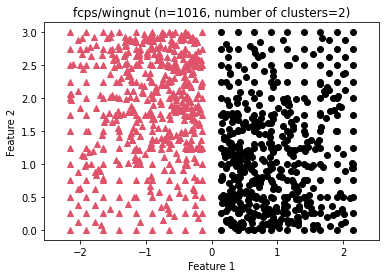

In [5]:
genieclust.plots.plot_scatter(X, labels=labels_true)
plt.title("%s (n=%d, number of clusters=%d)" % (dataset, X.shape[0], n_clusters))
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.axis("equal")
plt.show()

#1.K-Means σε υλοποίηση scikit-learn

Στον k-means ορίζουμε εμείς τον αριθμό των συστάδων που θέλουμε να εντοπίσει (στην περίπτωση μας 2). Σε κάθε μία από τις δύο συστάδες θα ανήκουν οι παρατηρήσεις όπου η απόσταση τους είναι πιο κοντά στο κέντρο της συστάδας. 

Βλέπωντας το αποτέλεσμα της πρόβλεψης παρατηρούμε πως ο kmeans έχει μία καλή επίδοση αλλά ταξινομεί σε λάθος συστάδες ορισμένα σημεία που βρίσκονται πιο κοντά στις πυκνές περιοχές, καθώς τα κέντρα των συστάδων βρίσκονται στις δύο πυκνές περιοχές. Έτσι για παράδειγμα ένα σημείο με θετικό feature 1 κοντά στο 0 (και feature 2 κοντά στο 3) ταξινομείται λανθασμένα μαζί με τα σημεία με αρνητικό feature 1 καθώς απέχει λιγότερη απόσταση από το κέντρο της συστάδας τους.

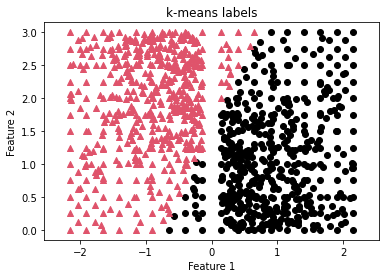

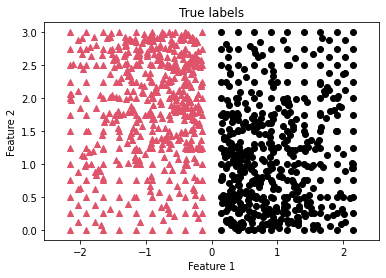

In [7]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=n_clusters, random_state=50)
labels_kmeans = km.fit_predict(X)

genieclust.plots.plot_scatter(X, labels=labels_kmeans)
plt.title("k-means labels")
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.axis("equal")
plt.show()

genieclust.plots.plot_scatter(X, labels=labels_true)
plt.title("True labels")
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.axis("equal")
plt.show()

In [8]:
print("Adjusted Rand Index:",metrics.adjusted_rand_score(labels_true, labels_kmeans))
print("Adjusted Mutual Information:",metrics.adjusted_mutual_info_score(labels_true, labels_kmeans))
print("V-measure:",metrics.v_measure_score(labels_true, labels_kmeans))

Adjusted Rand Index: 0.859497168372491
Adjusted Mutual Information: 0.7742402743924102
V-measure: 0.7744007983089454


#2.HAC με συνδέσμους "Single", "Average", "Complete", και "Ward" σε υλοποίηση fastcluster

Στην ιεραρχική σωρευτική συσταδοποίηση (HAC) δίνουμε εμείς τον αριθμό των clusters. Ο τύπος των συνδέσμων μεταξύ συστάδων μπορεί να είναι single, average, complete και ward. Με τους τρεις πρώτους συνδέσμους ο αλγόριθμος έχει 100% επιτυχία, ενώ με τον σύνδεσμο ward έχει αρκετά πιο χαμηλή. Αυτό συμβαίνει καθώς ο σύνδεσμος ward ελαχιστοποιεί την διακύμανση των συστάδων που θα ενωθούν και όπως είπαμε έχουμε "δύο γωνίες" με πυκνά δεδομένα. Επίσης, αξίζει να σημειωθεί πως ο Ward HAC δεν τα πηγαίνει τόσο καλά σε γραμμικά διαχωρίσιμα δεδομένα.

In [ ]:
pip install fastcluster

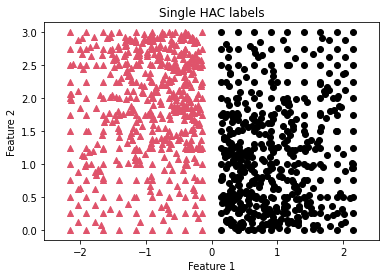

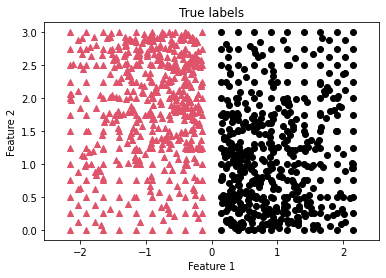

In [9]:
import fastcluster
from scipy.cluster.hierarchy import fcluster

single = fastcluster.single(X)
labels_single = fcluster(single, n_clusters, criterion='maxclust')-1

genieclust.plots.plot_scatter(X, labels=labels_single)
plt.title("Single HAC labels")
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.axis("equal")
plt.show()

genieclust.plots.plot_scatter(X, labels=labels_true)
plt.title("True labels")
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.axis("equal")
plt.show()

In [10]:
print("Adjusted Rand Index:",metrics.adjusted_rand_score(labels_true, labels_single))
print("Adjusted Mutual Information:",metrics.adjusted_mutual_info_score(labels_true, labels_single))
print("V-measure:",metrics.v_measure_score(labels_true, labels_single))

Adjusted Rand Index: 1.0
Adjusted Mutual Information: 1.0
V-measure: 1.0


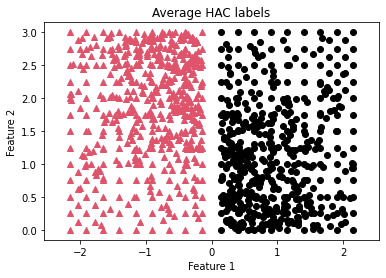

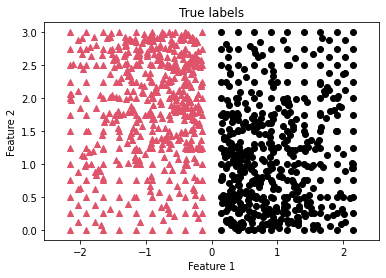

In [11]:
average = fastcluster.average(X)
labels_average = fcluster(average, n_clusters, criterion='maxclust')%2

genieclust.plots.plot_scatter(X, labels=labels_average)
plt.title("Average HAC labels")
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.axis("equal")
plt.show()

genieclust.plots.plot_scatter(X, labels=labels_true)
plt.title("True labels")
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.axis("equal")
plt.show()

In [12]:
print("Adjusted Rand Index:",metrics.adjusted_rand_score(labels_true, labels_average))
print("Adjusted Mutual Information:",metrics.adjusted_mutual_info_score(labels_true, labels_average))
print("V-measure:",metrics.v_measure_score(labels_true, labels_average))

Adjusted Rand Index: 1.0
Adjusted Mutual Information: 1.0
V-measure: 1.0


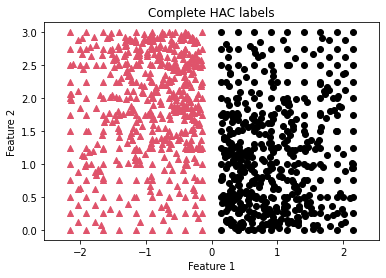

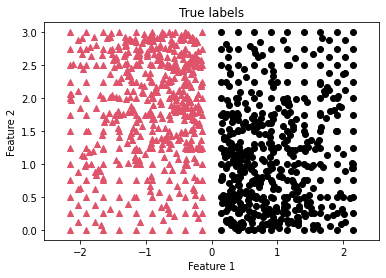

In [13]:
complete = fastcluster.complete(X)
labels_complete = fcluster(complete, n_clusters, criterion='maxclust')-1

genieclust.plots.plot_scatter(X, labels=labels_complete)
plt.title("Complete HAC labels")
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.axis("equal")
plt.show()

genieclust.plots.plot_scatter(X, labels=labels_true)
plt.title("True labels")
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.axis("equal")
plt.show()

In [14]:
print("Adjusted Rand Index:",metrics.adjusted_rand_score(labels_true, labels_complete))
print("Adjusted Mutual Information:",metrics.adjusted_mutual_info_score(labels_true, labels_complete))
print("V-measure:",metrics.v_measure_score(labels_true, labels_complete))

Adjusted Rand Index: 1.0
Adjusted Mutual Information: 1.0
V-measure: 1.0


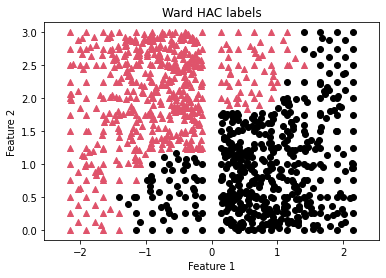

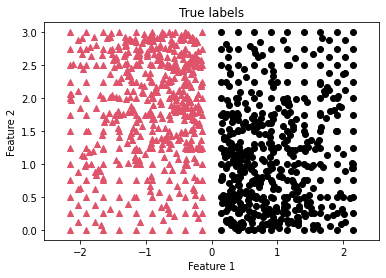

In [15]:
ward = fastcluster.ward(X)
labels_ward = fcluster(ward, n_clusters, criterion='maxclust')-1

genieclust.plots.plot_scatter(X, labels=labels_ward)
plt.title("Ward HAC labels")
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.axis("equal")
plt.show()

genieclust.plots.plot_scatter(X, labels=labels_true)
plt.title("True labels")
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.axis("equal")
plt.show()

In [16]:
print("Adjusted Rand Index:",metrics.adjusted_rand_score(labels_true, labels_ward))
print("Adjusted Mutual Information:",metrics.adjusted_mutual_info_score(labels_true, labels_ward))
print("V-measure:",metrics.v_measure_score(labels_true, labels_ward))

Adjusted Rand Index: 0.6011477451948987
Adjusted Mutual Information: 0.4931091169020675
V-measure: 0.4934695354632027


#3.GMM σε υλοποίηση scikit-learn

Το Gaussian Mixture model υποθέτει ότι όλα τα σημεία δεδομένων δημιουργούνται από ένα μείγμα πεπερασμένου αριθμού Gaussian κατανομών με άγνωστες παραμέτρους. Κάποιος μπορεί να σκεφτεί τα Gaussian Mixture models ως γενικευμένη ομαδοποίηση k-means που ενσωματώνει πληροφορίες σχετικά με τη δομή συνδιακύμανσης των δεδομένων καθώς και τα κέντρα των υποβόσκων Gaussians.

Στο dataset μας λοιπόν που τα δεδομένα δεν φαίνεται να προέκυψαν από Γκαουσιανές κατανομές αναμένουμε η επίδοση του να είναι σχεδόν ίδια με του k-means, που πράγματι είναι ακριβώς έτσι.

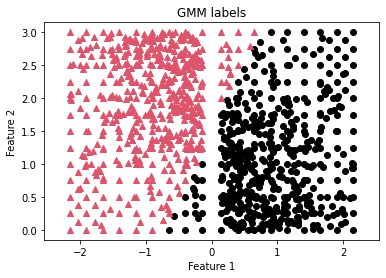

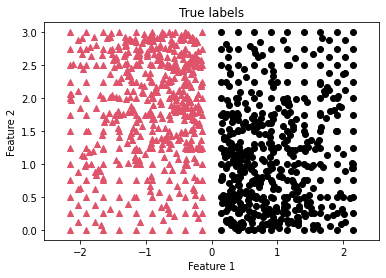

In [17]:
from sklearn.mixture import GaussianMixture

GMM = GaussianMixture(n_components = n_clusters, random_state=50)
labels_GMM = GMM.fit_predict(X)

genieclust.plots.plot_scatter(X, labels=labels_GMM)
plt.title("GMM labels")
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.axis("equal")
plt.show()

genieclust.plots.plot_scatter(X, labels=labels_true)
plt.title("True labels")
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.axis("equal")
plt.show()

In [18]:
print("Adjusted Rand Index:",metrics.adjusted_rand_score(labels_true, labels_GMM))
print("Adjusted Mutual Information:",metrics.adjusted_mutual_info_score(labels_true, labels_GMM))
print("V-measure:",metrics.v_measure_score(labels_true, labels_GMM))

Adjusted Rand Index: 0.8631549038246006
Adjusted Mutual Information: 0.7788967621629845
V-measure: 0.7790539749152765


#4.DBSCAN σε υλοποίηση scikit-learn

Ο DBSCAN δυσκολεύεται όταν οι συστάδες έχουν μεταβλητή πυκνότητα. Ωστόσο με τις κατάλληλες παραμέτρους που αφορούν το μέτρο ακτίνας και το ελάχιστο μέγεθος γειτονιάς κατάφερε να προβλέψει τέλεια τις δύο συστάδες. Χωρίς τις κατάλληλες παραμέτρους αναγνωρίζει μέρος των δεδομένων ως θόρυβο (Τα δεδομένα που απέχουν πιο πολύ από τις 2 γωνίες που εντοπίζουμε σημεία με αυξημένη πυκνότητα).

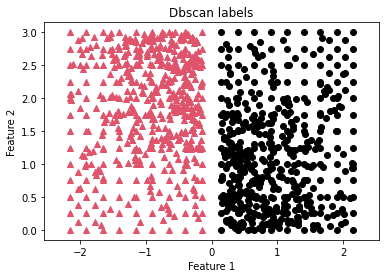

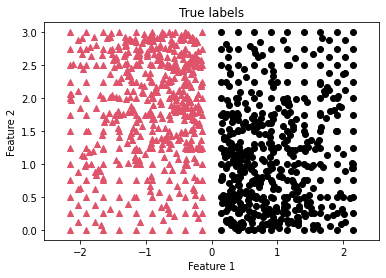

In [19]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.25,min_samples=2, n_jobs=-1)
labels_DBSCAN = dbscan.fit_predict(X)

genieclust.plots.plot_scatter(X, labels=labels_DBSCAN)
plt.title("Dbscan labels")
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.axis("equal")
plt.show()

genieclust.plots.plot_scatter(X, labels=labels_true)
plt.title("True labels")
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.axis("equal")
plt.show()

In [20]:
print("Adjusted Rand Index:",metrics.adjusted_rand_score(labels_true, labels_DBSCAN))
print("Adjusted Mutual Information:",metrics.adjusted_mutual_info_score(labels_true, labels_DBSCAN))
print("V-measure:",metrics.v_measure_score(labels_true, labels_DBSCAN))

Adjusted Rand Index: 1.0
Adjusted Mutual Information: 1.0
V-measure: 1.0


#5.HDBSCAN σε υλοποίηση hdbscan 

Παρόμοια με τον DBSCAN ο HDBSCAN με την κατάλληλη παράμετρο min cluster size καταφέρνει να εντοπίσει τέλεια τις δύο συστάδες.

In [ ]:
pip install hdbscan

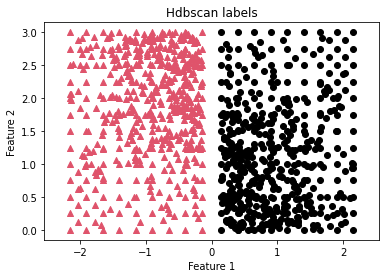

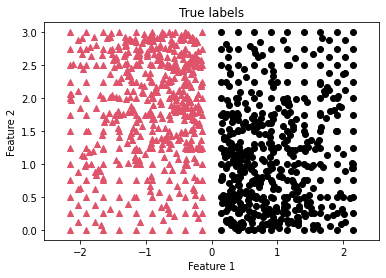

In [22]:
import hdbscan

labels_hdbscan = hdbscan.HDBSCAN(min_cluster_size=3).fit_predict(X)

genieclust.plots.plot_scatter(X, labels=labels_hdbscan)
plt.title("Hdbscan labels")
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.axis("equal")
plt.show()

genieclust.plots.plot_scatter(X, labels=labels_true)
plt.title("True labels")
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.axis("equal")
plt.show()

In [23]:
print("Adjusted Rand Index:",metrics.adjusted_rand_score(labels_true, labels_hdbscan))
print("Adjusted Mutual Information:",metrics.adjusted_mutual_info_score(labels_true, labels_hdbscan))
print("V-measure:",metrics.v_measure_score(labels_true, labels_hdbscan))

Adjusted Rand Index: 1.0
Adjusted Mutual Information: 1.0
V-measure: 1.0


#6.SOM σε υλοποίηση sklearn-som

Με τις παραμέτρους του SOM καθορίζουμε τον αριθμό των συστάδων που θέλουμε να δημιουργήσει. Όπως περιμέναμε η απόδοση του είναι πολύ κοντά στην απόδοση του k-means, αντιμετωπίζοντας πρόβλημα στην συσταδοποίηση σημείων κοντά στις πυκνές περιοχές.

In [ ]:
pip install sklearn-som

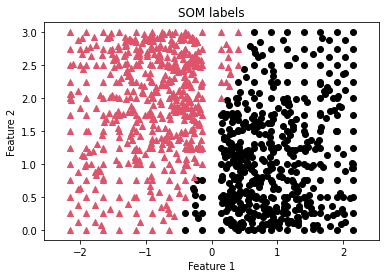

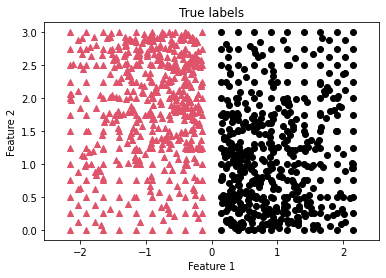

In [25]:
from sklearn_som.som import SOM

som = SOM(m=2, n=1, dim=2, random_state=50)
labels_som = som.fit_predict(X)

genieclust.plots.plot_scatter(X, labels=labels_som)
plt.title("SOM labels")
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.axis("equal")
plt.show()

genieclust.plots.plot_scatter(X, labels=labels_true)
plt.title("True labels")
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.axis("equal")
plt.show()

In [26]:
print("Adjusted Rand Index:",metrics.adjusted_rand_score(labels_true, labels_som))
print("Adjusted Mutual Information:",metrics.adjusted_mutual_info_score(labels_true, labels_som))
print("V-measure:",metrics.v_measure_score(labels_true, labels_som))

Adjusted Rand Index: 0.8889762740047693
Adjusted Mutual Information: 0.8130461790148799
V-measure: 0.8131791119233849


#Αποτελέσματα και Συμπεράσματα

Συγκεντρωτικά για όλους τους αλγορίθμους συσταδοποίησης έχουμε τα εξής αποτελέσματα:

|  Algorithm | Adgusted Rand Index   | Adjusted Mutual Info | V-measure     |
| :----:       |    :----:   |   :---: |  :---: |
| *Single HAC* |1.0|1.0|1.0|
| *Average HAC*|1.0|1.0|1.0|
| *Complete HAC* |1.0|1.0|1.0|
| *DBSCAN* |1.0|1.0|1.0|
| *HDBSCAN*|1.0|1.0|1.0|
| *SOM*|0.8889|0.813|0.8132|
| *GMM* |0.8632|0.7789|0.7791|
| *K-Means* |0.8595|0.7742|0.7744|
| *Ward HAC*|0.6011|0.4931|0.4934|


Οι αλγόριθμοι Single HAC, Average HAC, Complete HAC, DBSCAN και HDBSCAN όπως είδαμε έχουν 100% επιτυχία στην αναγνώριση των συστάδων. Για παράδειγμα θα φτιάξουμε το confusion matrix του DBSCAN που φαίνεται παρακάτω:

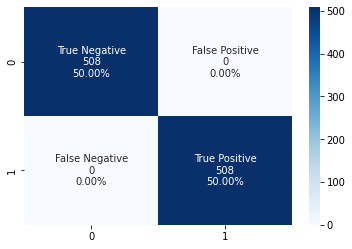

In [27]:
#DBSCAN Confusion matrix

from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(labels_true, labels_DBSCAN)

group_names = ['True Negative','False Positive','False Negative','True Positive']
group_counts = ["{0:0.0f}".format(value) for value in
                cnf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cnf_matrix.flatten()/np.sum(cnf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cnf_matrix, annot=labels, fmt='', cmap='Blues')

Ο χειρότερος αλγόριθμος στην περίπτωση μας είναι ο HAC Ward, το confusion matrix του οποίου φαίνεται παρακάτω:

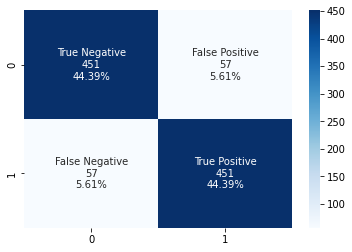

In [28]:
#HAC Ward Confusion matrix 

cnf_matrix = confusion_matrix(labels_true, labels_ward)

group_names = ['True Negative','False Positive','False Negative','True Positive']
group_counts = ["{0:0.0f}".format(value) for value in
                cnf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cnf_matrix.flatten()/np.sum(cnf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cnf_matrix, annot=labels, fmt='', cmap='Blues')

Για το συγκεκριμένο dataset θα πρότεινα οποιονδήποτε αλγόριθμο από αυτούς που εμφανίζουν 100% επιτυχία στις προβλέψεις (Single HAC, Average HAC, Complete HAC, DBSCAN και HDBSCAN). Ωστόσο αξίζει να σημειώσουμε πως στους Single HAC, Average HAC και Complete HAC δίνουμε εξαρχής τον αριθμό των συστάδων (κάτι το οποίο γενικά δεν γνωρίζουμε στην πραγματικότητα), ενώ οι DBSCAN και HDBSCAN το υπολογίζουν μέσω των παραμέτρων που διαθέτουν. Ωστόσο, σε αυτους τους δύο χωρίς τις κατάλληλες παραμέτρους μέρος των δεδομένων μπορεί να χαρακτηριστεί θόρυβος.

#B.Μεγάλο Dataset

In [29]:
github = "https://raw.githubusercontent.com/gagolews/clustering-data-v1/master/"

dataset = "h2mg/h2mg_128_90" 
data_url = github + dataset + ".data.gz"
labels_url = github + dataset + ".labels0.gz"

!wget $data_url
!wget $labels_url

X = np.loadtxt(dataset.split("/")[1]+".data.gz", ndmin=2)
labels_true = np.loadtxt(dataset.split("/")[1]+".labels0.gz", dtype=np.intc)-1
n_clusters = len(np.unique(labels_true))

--2022-12-23 11:43:09--  https://raw.githubusercontent.com/gagolews/clustering-data-v1/master/h2mg/h2mg_128_90.data.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 497217 (486K) [application/octet-stream]
Saving to: ‘h2mg_128_90.data.gz’

h2mg_128_90.data.gz 100%[===================>] 485.56K  --.-KB/s    in 0.005s  

2022-12-23 11:43:09 (87.1 MB/s) - ‘h2mg_128_90.data.gz’ saved [497217/497217]

--2022-12-23 11:43:09--  https://raw.githubusercontent.com/gagolews/clustering-data-v1/master/h2mg/h2mg_128_90.labels0.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, 

In [30]:
print(f"The h2mg_128_90 dataset has {X.shape[0]} rows of data")
print("The number of features are:", X.shape[1])  
print("The unique number of clusters are:", n_clusters)

The h2mg_128_90 dataset has 2048 rows of data
The number of features are: 128
The unique number of clusters are: 2


In [31]:
sum1 = 0
sum2 = 0

for i in labels_true :
    if i == 0:
       sum1 = sum1 + 1
    else: 
       sum2 = sum2 + 1

print(sum1,sum2)

1024 1024


Το μεγάλο dataset που έχει την ονομασία h2mg_128_90 έχει 2048 σειρές δεδομένων, όπου τα δεδομένα αποτελούνται από 128 χαρακτηριστικά. Τα δεδομένα κατηγοριοποιούνται σε 2 clusters σε ποσοστό 50-50. Αρχικά θα κάνουμε μία γραφική αναπαράσταση των δεδομένων χρησιμοποιώντας PCA με 2 και 3 χαρακτηριστικά (απλά για να δούμε πως περίπου είναι τα δεδομένα, όπου θα διαπιστώσουμε οτι οι συστάδες είναι πολύ μπερδεμένες μεταξύ τους) και ύστερα θα εφαρμόσουμε τους αλγορίθμους που εφαρμόσαμε και στο 2D Dataset.

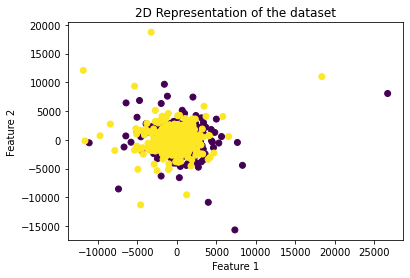

In [32]:
#PCA με 2 χαρακτηριστικά - 2D αναπαράσταση
from sklearn.decomposition import PCA

PCA2D = PCA(n_components = 2).fit_transform(X)
plt.scatter(PCA2D[:,0], PCA2D[:,1], c = labels_true) #χρωματίζω με βάση τα labels των clusters
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('2D Representation of the dataset')

plt.show()

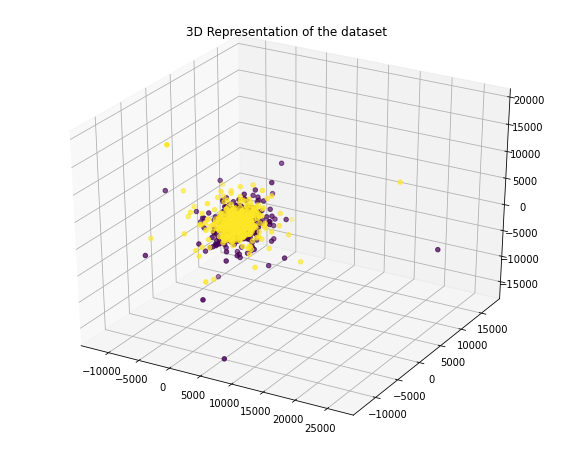

In [33]:
#PCA με 3 χαρακτηριστικά - 3D αναπαράσταση

from mpl_toolkits import mplot3d
PCA3D = PCA(n_components =3).fit_transform(X)

fig = plt.figure(figsize =(10, 8))
ax = plt.axes(projection ="3d")
ax.scatter3D(PCA3D[:,0], PCA3D[:,1], PCA3D[:,2], c = labels_true)
plt.title('3D Representation of the dataset')
plt.show()

#1.K-Means σε υλοποίηση scikit-learn

In [34]:
start_time = time.time()
km = KMeans(n_clusters=n_clusters, random_state=50)
labels_kmeans = km.fit_predict(X)
end_time = time.time()
t = end_time - start_time

print("Adjusted Rand Index:",metrics.adjusted_rand_score(labels_true, labels_kmeans))
print("Adjusted Mutual Information:",metrics.adjusted_mutual_info_score(labels_true, labels_kmeans))
print("V-measure:",metrics.v_measure_score(labels_true, labels_kmeans))
print("Total time needed:",t)

Adjusted Rand Index: 0.0004896840393359606
Adjusted Mutual Information: 0.0015666718233924967
V-measure: 0.002061272936646589
Total time needed: 0.11498761177062988


#2.HAC με συνδέσμους "Single", "Average", "Complete", και "Ward" σε υλοποίηση fastcluster

In [35]:
start_time = time.time()
single = fastcluster.single(X)
labels_single = fcluster(single, n_clusters, criterion='maxclust')%2
end_time = time.time()
t = end_time - start_time

print("Adjusted Rand Index:",metrics.adjusted_rand_score(labels_true, labels_single))
print("Adjusted Mutual Information:",metrics.adjusted_mutual_info_score(labels_true, labels_single))
print("V-measure:",metrics.v_measure_score(labels_true, labels_single))
print("Total time needed:",t)

Adjusted Rand Index: 0.0
Adjusted Mutual Information: 2.3732639916458956e-16
V-measure: 0.0009710074111617752
Total time needed: 0.12517976760864258


In [36]:
start_time = time.time()
average = fastcluster.average(X)
labels_average = fcluster(average, n_clusters, criterion='maxclust')%2
end_time = time.time()
t = end_time - start_time

print("Adjusted Rand Index:",metrics.adjusted_rand_score(labels_true, labels_average))
print("Adjusted Mutual Information:",metrics.adjusted_mutual_info_score(labels_true, labels_average))
print("V-measure:",metrics.v_measure_score(labels_true, labels_average))
print("Total time needed:",t)

Adjusted Rand Index: 0.0
Adjusted Mutual Information: 2.3732639916458956e-16
V-measure: 0.0009710074111617752
Total time needed: 0.1358811855316162


In [37]:
start_time = time.time()
complete = fastcluster.complete(X)
labels_complete = fcluster(complete, n_clusters, criterion='maxclust')%2
end_time = time.time()
t = end_time - start_time

print("Adjusted Rand Index:",metrics.adjusted_rand_score(labels_true, labels_complete))
print("Adjusted Mutual Information:",metrics.adjusted_mutual_info_score(labels_true, labels_complete))
print("V-measure:",metrics.v_measure_score(labels_true, labels_complete))
print("Total time needed:",t)

Adjusted Rand Index: -3.8053976002757408e-06
Adjusted Mutual Information: -0.0006600790780447283
V-measure: 0.00013875960697098057
Total time needed: 0.15150117874145508


In [38]:
start_time = time.time()
ward = fastcluster.ward(X)
labels_ward = fcluster(ward, n_clusters, criterion='maxclust')%2
end_time = time.time()
t = end_time - start_time

print("Adjusted Rand Index:",metrics.adjusted_rand_score(labels_true, labels_ward))
print("Adjusted Mutual Information:",metrics.adjusted_mutual_info_score(labels_true, labels_ward))
print("V-measure:",metrics.v_measure_score(labels_true, labels_ward))
print("Total time needed:",t)

Adjusted Rand Index: -1.9045587438425408e-06
Adjusted Mutual Information: -0.0006623526285104208
V-measure: 0.00023595959948222636
Total time needed: 0.13527345657348633


#3.GMM σε υλοποίηση scikit-learn

In [39]:
start_time = time.time()
GMM = GaussianMixture(n_components = n_clusters)
labels_GMM = GMM.fit_predict(X)
end_time = time.time()
t = end_time - start_time

print("Adjusted Rand Index:",metrics.adjusted_rand_score(labels_true, labels_GMM))
print("Adjusted Mutual Information:",metrics.adjusted_mutual_info_score(labels_true, labels_GMM))
print("V-measure:",metrics.v_measure_score(labels_true, labels_GMM))
print("Total time needed:",t)

Adjusted Rand Index: 0.0
Adjusted Mutual Information: 2.374820230328942e-16
V-measure: 0.0009710074111617752
Total time needed: 0.1767287254333496


#4.DBSCAN σε υλοποίηση scikit-learn

In [40]:
start_time = time.time()
dbscan = DBSCAN(eps=1100,min_samples=3, n_jobs=-1) #after trials
labels_DBSCAN = dbscan.fit_predict(X)
end_time = time.time()
t = end_time - start_time

print("Adjusted Rand Index:",metrics.adjusted_rand_score(labels_true, labels_DBSCAN))
print("Adjusted Mutual Information:",metrics.adjusted_mutual_info_score(labels_true, labels_DBSCAN))
print("V-measure:",metrics.v_measure_score(labels_true, labels_DBSCAN))
print("Total time needed:",t)

Adjusted Rand Index: 0.005891865548363464
Adjusted Mutual Information: 0.10466621783903392
V-measure: 0.10552899438990096
Total time needed: 0.16158342361450195


#5.HDBSCAN σε υλοποίηση hdbscan

In [50]:
start_time = time.time()
labels_hdbscan = hdbscan.HDBSCAN(min_cluster_size=3).fit_predict(X)
end_time = time.time()
t = end_time - start_time

print("Adjusted Rand Index:",metrics.adjusted_rand_score(labels_true, labels_hdbscan))
print("Adjusted Mutual Information:",metrics.adjusted_mutual_info_score(labels_true, labels_hdbscan))
print("V-measure:",metrics.v_measure_score(labels_true, labels_hdbscan))
print("Total time needed:",t)

Adjusted Rand Index: 0.005891865548363464
Adjusted Mutual Information: 0.10466621783903392
V-measure: 0.10552899438990096
Total time needed: 0.8395354747772217


#6.SOM σε υλοποίηση sklearn-som

In [42]:
start_time = time.time()
som = SOM(m=2, n=128, dim=128, random_state=50)
labels_som = som.fit_predict(X)
end_time = time.time()
t = end_time - start_time

print("Adjusted Rand Index:",metrics.adjusted_rand_score(labels_true, labels_som))
print("Adjusted Mutual Information:",metrics.adjusted_mutual_info_score(labels_true, labels_som))
print("V-measure:",metrics.v_measure_score(labels_true, labels_som))
print("Total time needed:",t)

Adjusted Rand Index: 0.003173406671295964
Adjusted Mutual Information: 0.0043809659408743954
V-measure: 0.03182202611442492
Total time needed: 2.269763231277466


#Αποτελέσματα και Συμπεράσματα

Συγκεντρωτικά τα αποτελέσματα σε πίνακα markdown φαίνονται παρακάτω:

|  Algorithm | Adgusted Rand Index   | Adjusted Mutual Info | V-measure |Time|
| :----:       |    :----:   |   :---: |  :---: |:---: |
| *DBSCAN* |0.0059|0.1047|0.1055|0.162|
| *HDBSCAN*|0.0059|0.1047|0.1055|0.839|
| *SOM*|0.0317|0.0043|0.0318|2.269|
| *K-Means* |0.0004|0.0016|0.002|0.115|
| *Average HAC*|0.0|0.0|0.0009|0.136|
| *Single HAC* |0.0|0.0|0.0009|0.125|
| *GMM* |0.0|0.0|0.0009|0.177|
| *Ward HAC*|0.0|-0.0006|0.0002|0.135|
| *Complete HAC* |0.0|-0.0006|0.0001|0.152|

Παρατηρούμε πως όλοι οι αλγόριθμοι έχουν πάρα πολύ κακές αποδόσεις. Λίγο καλύτερες αποδόσεις έχουν οι αλγόριθμοι HDBSCAN, DBSCAN και SOM αλλά παραμένουν πολύ χαμηλές. Οι αλγόριθμοι HDBSCAN και DBSCAN κάνουν ακριβώς τις ίδιες προβλέψεις, κάτι το οποίο βλέπουμε αν σχεδιάσουμε και τα αντίστοιχα confusion matrices. Αξίζει να παρατηρήσουμε πως αυτοί οι δύο αλγόριθμοι δημιουργούν 3 συστάδες (όχι 2 που γνωρίζουμε οτι έχουμε) καθώς η μία αφορά δεδομένα που θεωρούνται θόρυβος, όπου το μεγαλύτερο μέρος των δεδομένων κατηγοριοποιείται σε αυτήν.

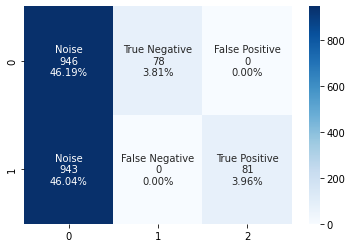

In [44]:
#HDBSCAN Confusion matrix 

cnf_matrix = confusion_matrix(labels_true, labels_hdbscan)
cnf_matrix = np.delete(cnf_matrix, (0), axis=0)

group_names = ['Noise', 'True Negative','False Positive','Noise','False Negative','True Positive']
group_counts = ["{0:0.0f}".format(value) for value in
                cnf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cnf_matrix.flatten()/np.sum(cnf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,3)
sns.heatmap(cnf_matrix,annot=labels, fmt='', cmap='Blues')

#Note: Κανονικά οριζόντια είναι -1,0,1 (και όχι 0,1,2) όπου -1 είναι ο θόρυβος

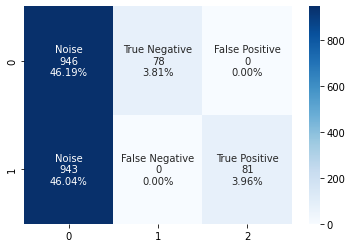

In [43]:
#DBSCAN Confusion matrix 

cnf_matrix = confusion_matrix(labels_true, labels_DBSCAN)
cnf_matrix = np.delete(cnf_matrix, (0), axis=0)

group_names = ['Noise', 'True Negative','False Positive','Noise','False Negative','True Positive']
group_counts = ["{0:0.0f}".format(value) for value in
                cnf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cnf_matrix.flatten()/np.sum(cnf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,3)
sns.heatmap(cnf_matrix,annot=labels, fmt='', cmap='Blues')

#Note: Κανονικά οριζόντια είναι -1,0,1 (και όχι 0,1,2) όπου -1 είναι ο θόρυβος

Ένας από τους χειρότερους αλγορίθμους είναι ο HAC με σύνδεσμο Complete, όπου ο confusion matrix του φαίνεται παρακάτω. Πρακτικά είναι σαν να βάζει σχεδόν όλα τα δεδομένα σε μία συστάδα.

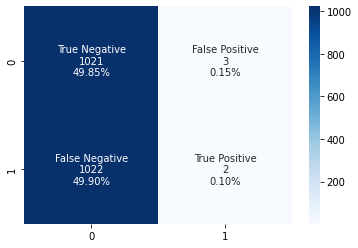

In [132]:
#Complete HAC Confusion matrix 

cnf_matrix = confusion_matrix(labels_true, labels_complete)

group_names = ['True Negative','False Positive','False Negative','True Positive']
group_counts = ["{0:0.0f}".format(value) for value in
                cnf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cnf_matrix.flatten()/np.sum(cnf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cnf_matrix, annot=labels, fmt='', cmap='Blues')

Όλα τα σκορ των αλγορίθμων είναι πολύ κακά κάτι που οφείλεται κυρίως στην κατάρα της διαστατικότητας καθώς το dataset έχει 128 χαρακτηριστικά. Με αυτά τα δεδομένα οι αλγόριθμοι DBSCAN και HDBSCAN παράγουν κάπως καλύτερα αποτελέσματα αλλά οι αποδόσεις είναι πολύ χαμηλές. Θα μπορούσαμε να εξετάσουμε τρόπους μείωσης διαστατικότητας όπως PCA και Variance Threshold αλλά και άλλες τεχνικές όπως κανονικοποίηση των δεδομένων. Με κάποιες προσπάθειες που δοκίμασα δεν οδηγήθηκα σε πολύ καλύτερα αποτελέσματα.